In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [4]:
def expand_array(short_array):
    long_array = np.zeros(6084)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(78) * (78 + 1)] = short_array
    return long_array

def expand_timeseries(short_timeseries):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((day_range,6084))
    for i in range(day_range):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries


def compress_timeseries(long_timeseries):
    compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape
    
    for i in range(day_range):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def compress_array(long_array):
    return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas



with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
    pop_dict = pickle.load(file)
    
# Assuming pop_dict is a pandas DataFrame
pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
pop_dict = dict(sorted(pop_dict.items()))
    
# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
borough_list = np.array(range(15))+1
    
with open("ba_big station list.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("station_comuna_dict.pkl", 'rb') as f:
    station_comuna_dict = pickle.load(f)
    
station_borough_list = list(station_comuna_dict.values())
    
with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("BA_Covid_Data.pkl", 'rb') as f:
    covid_df = pickle.load(f)
    
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values

    
with open("ba_all_paths.pkl", 'rb') as f:
    all_paths = pickle.load(f)
    
# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
    
    
################################################################################################
################################################################################################
################################################################################################
################################################################################################

def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-08-07") & 
        (covid_df['comuna'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-07-23"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-08-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    
    
    return station_timeseries

def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-4-18"
    earliest_nonzero_date = "2020-04-05"
    five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]
print(day_range)

working_timeseries = expand_timeseries(all_station_timeseries)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)
    
with open("Buenos Aires Home Patches.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
# Load files
with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
Nj = pop_vector @ p_matrix

Nj_safe = Nj.copy()
Nj_safe[Nj_safe == 0] = 1
Nj = Nj_safe.copy()

with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

np.set_printoptions(suppress=True)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)
        
gamma = 1/5

with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet = pickle.load(file)
    
home_betas = best_beta_yet[:78]

current_cases,cum_cases

/tmp/ipykernel_1872065/3961419354.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


14


(array([0.53309146, 3.06198276, 1.36098964, 0.84738171, 2.87982388,
        0.34494154, 3.1537043 , 1.50258624, 3.68067577, 2.53600832,
        1.62879848, 0.79005452, 1.89181386, 2.34665845, 3.49440066,
        2.29503324, 0.98256074, 0.58274214, 1.3825862 , 6.35516468,
        2.82338537, 1.11138307, 1.21614967, 1.61165043, 1.7936081 ,
        6.26534752, 1.80360422, 2.11711224, 1.53761633, 2.06430192,
        1.17870608, 0.59058172, 1.32750228, 2.30932008, 6.64022169,
        3.50414972, 1.27523841, 3.72712931, 3.27605848, 9.73465248,
        1.52214862, 3.91770601, 1.86672538, 0.69510946, 1.36670018,
        2.31210395, 1.9770448 , 1.86616643, 3.07474284, 0.56183659,
        3.98705662, 3.72163626, 2.89957563, 3.36122794, 1.14553453,
        1.12199615, 1.9188274 , 0.41549776, 1.68324814, 1.76390558,
        2.15869142, 1.38876446, 3.14210942, 3.51984935, 1.54178414,
        2.75762032, 0.97994755, 1.12889957, 1.6684458 , 1.96250828,
        2.7576425 , 0.96780152, 2.69703174, 1.04

FULL CITY MODEL

In [16]:
cum_cases.shape

(6084,)

In [5]:

import numpy as np
from scipy.optimize import minimize

timesteps = day_range
total_pop = np.sum(pop_vector)
full_timeseries = np.sum(all_station_timeseries,axis=0)

# Define the SIR model
def SIR(y, beta, gamma):
    S, I, I_total = y
    N = total_pop
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dItotaldt = beta * S * I / N
    return np.array([dSdt, dIdt, dItotaldt]).flatten()

# Function to simulate SIR model given beta
def simulate(beta, gamma):
    sol = np.zeros([timesteps, 3])
    
    N = total_pop
    I0 = np.sum(current_cases)
    I0_total = np.sum(cum_cases[home_patches])
    S0 = N-I0
    
    sol[0] = np.array([S0, I0, I0_total])
    
    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i], beta, gamma)
   
    
    return sol.T[2]  # Return only I_total

# Define loss function (sum of squared errors)
def loss(beta):
    I_total_simulated = simulate(beta, gamma)
    return np.sum((I_total_simulated - full_timeseries) ** 2)

# Optimize beta
beta_initial = 0.3
result = minimize(loss, beta_initial, method='L-BFGS-B', bounds=[(0, 1)])

# Best fit beta
best_beta = result.x[0]
print("Optimized beta:", best_beta)


Optimized beta: 0.2723752796756145


In [6]:
def SIR(y,beta,gamma):
    S,I,I_total = y
    N = total_pop
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dItotaldt = beta*S*I/N
    return np.array([dSdt,dIdt,dItotaldt])

N = total_pop
I0 = np.sum(current_cases)
I0_total = np.sum(cum_cases)
S0 = N-I0

beta = best_beta
gamma = 1/5

timesteps = all_station_timeseries.shape[1]
sol2 = np.zeros([timesteps,3])
sol2[0] = np.array([S0,I0,I0_total])

for i in range(timesteps-1):
    sol2[i+1] = sol2[i] + SIR(sol2[i],beta,gamma).ravel()

sol2

array([[1338885.722903  ,     173.        ,     659.        ],
       [1338838.60806741,     185.51483559,     706.11483559],
       [1338788.08671827,     198.93321762,     756.63618473],
       [1338733.91317867,     213.32011369,     810.80972433],
       [1338675.82414687,     228.74512275,     868.89875613],
       [1338613.53744582,     245.28279925,     931.18545718],
       [1338546.75068619,     263.01299903,     997.97221681],
       [1338475.139837  ,     282.02124842,    1069.583066  ],
       [1338398.35769805,     302.39913768,    1146.36520495],
       [1338316.03226769,     324.24474051,    1228.69063531],
       [1338227.76499921,     347.66306088,    1316.95790379],
       [1338133.12893899,     372.76650892,    1411.59396401],
       [1338031.66673883,     399.6754073 ,    1513.05616417],
       [1337922.88853476,     428.51852991,    1621.83436824]])

MODEL BY STATION

In [10]:
beta_array

NameError: name 'beta_array' is not defined

In [118]:
compress_array(cum_cases).shape

(251,)

In [7]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]

def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==246:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

In [8]:
import numpy as np
import pickle
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

# Load best beta so far
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)

print("Loaded best_beta_yet_0 with shape:", best_beta_yet_0.shape)

# Globals for tracking best result
best_beta = None
best_error = float('inf')

def SIR(y, beta, gamma, N):
    S, I, I_total = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dItotaldt = beta * S * I / N
    return np.array([dSdt, dIdt, dItotaldt])

def solve_SIR(params):
    S0, I0, I0_total, beta, gamma, timesteps = params
    sol = np.zeros((timesteps, 3))
    sol[0] = np.array([S0, I0, I0_total])
    for i in range(1, timesteps):
        sol[i] = sol[i-1] + SIR(sol[i-1], beta, gamma, N).ravel()
    output = sol.T[2]
    return output  # Return cumulative I cases


def expand_concise_betas(home_patches, travel_patches, concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    return long_beta


def error_function(beta, data, pop_dict,i):
    global best_beta, best_error

    short_pop_vector = np.array(list(pop_dict.values()))

    I0 = current_cases[i]
    S0 = short_pop_vector[i] - I0
    I_total_0 = cum_cases[home_patches][i]
    gamma = 1 / 5

    params = [S0, I0, I_total_0, beta, gamma, int(data[-1, 0])+1]

    I_sum_model = solve_SIR(params)
    raw_real_data = data[:, 1:]

    normalizer = short_pop_vector

    real_data = raw_real_data.ravel()
    model_data = I_sum_model

    if real_data.shape != model_data.shape:
        raise ValueError(f"Shape mismatch: real_data {real_data.shape} vs model_data {model_data.shape}")

    error_matrix = (model_data - real_data) ** 2
    squared_error = np.sum(error_matrix)

    l1_penalty = 1e-4 * (1 + np.std(beta))
    l2_penalty = 1e-4 * (1 + np.mean(beta)**2)
    total_error = squared_error + l1_penalty + l2_penalty

    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        # print(f"New best beta found. Error: {best_error:.12f}")

    return total_error

def sir_simulation_fit_class(full_timeseries, pop_dict,i):
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], full_timeseries))

    initial_guess = 0.3
    beta_bounds = [(0.2, 0.8)]

    result = minimize(
        error_function,
        initial_guess,
        args=(data, pop_dict,i),
        method='Powell',
        bounds=beta_bounds
    )

    # print('Estimated beta:', result.x)
    # print('Final minimized error:', result.fun)
    return result.x

beta_array = np.zeros(78)
for i in range(78):
    N = short_pop_vector[i]
    
    
    # Adjust initial conditions
    
    I0 = current_cases[i]
    I0_total = compress_array(cum_cases)[i]
    S0 = N - I0
    
    beta_array[i] = sir_simulation_fit_class(all_station_timeseries[i], pop_dict,i)

beta_array

Loaded best_beta_yet_0 with shape: (79,)


/tmp/ipykernel_1872065/18721862.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_array[i] = sir_simulation_fit_class(all_station_timeseries[i], pop_dict,i)


array([0.25994526, 0.23828205, 0.31349923, 0.24640249, 0.26024255,
       0.25994525, 0.30550553, 0.25994527, 0.26024255, 0.25108594,
       0.31349923, 0.24640249, 0.30550553, 0.24640249, 0.2841726 ,
       0.26024255, 0.25994527, 0.25994527, 0.24640249, 0.27305933,
       0.25994528, 0.31349923, 0.24640249, 0.32242259, 0.32242259,
       0.26394065, 0.30550553, 0.24640249, 0.32242259, 0.31349923,
       0.24640249, 0.25994527, 0.25994527, 0.24640249, 0.2841726 ,
       0.2841726 , 0.25994527, 0.27305933, 0.23828205, 0.26394065,
       0.24640249, 0.27305933, 0.31349923, 0.25994527, 0.25994527,
       0.26024255, 0.32242259, 0.30550553, 0.26024255, 0.25994526,
       0.25108594, 0.25108594, 0.25108594, 0.2841726 , 0.24640249,
       0.24640249, 0.24640249, 0.25994526, 0.30550553, 0.25994527,
       0.25108594, 0.24640249, 0.23828205, 0.23828205, 0.25994527,
       0.26024255, 0.25994527, 0.25994527, 0.30550553, 0.25994527,
       0.30550553, 0.31349923, 0.25108594, 0.25994527, 0.32242

Now we test how it predicts the future

In [16]:
def SIR(y,beta,gamma):
    S,I,I_total = y
    N = np.sum(short_pop_vector)
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dItotaldt = beta*S*I/N
    return np.array([dSdt,dIdt,dItotaldt])

N = np.sum(short_pop_vector)
I0 = current_cases
I0_total = cum_cases[home_patches]
S0 = N-I0

beta = beta_array.copy()
gamma = 1/5

timesteps = all_station_timeseries.shape[1]
sol = np.zeros([timesteps,3,78])
sol[0] = np.array([S0,I0,I0_total])

for i in range(timesteps-1):
    sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)

sol

array([[[1339058.18981154, 1339055.66092024, 1339057.36191336, ...,
         1339058.14277405, 1339057.54752825, 1339056.00814309],
        [      0.53309146,       3.06198276,       1.36098964, ...,
               0.58012895,       1.17537475,       2.71475991],
        [      1.98697728,      10.36363397,       7.7122746 , ...,
               2.1622988 ,       4.11381164,       9.3782615 ]],

       [[1339058.05123699, 1339054.93130637, 1339056.9352446 , ...,
         1339057.99197235, 1339057.18844507, 1339055.33922084],
        [      0.56504772,       3.17920008,       1.51546047, ...,
               0.61490487,       1.29938298,       2.84073018],
        [      2.12555182,      11.09324784,       8.13894337, ...,
               2.31310051,       4.47289481,      10.04718375]],

       [[1339057.90435558, 1339054.17376219, 1339056.46014954, ...,
         1339057.83213082, 1339056.79147684, 1339054.63925961],
        [      0.59891958,       3.30090424,       1.68746343, ...,
    

(14,) (14,)


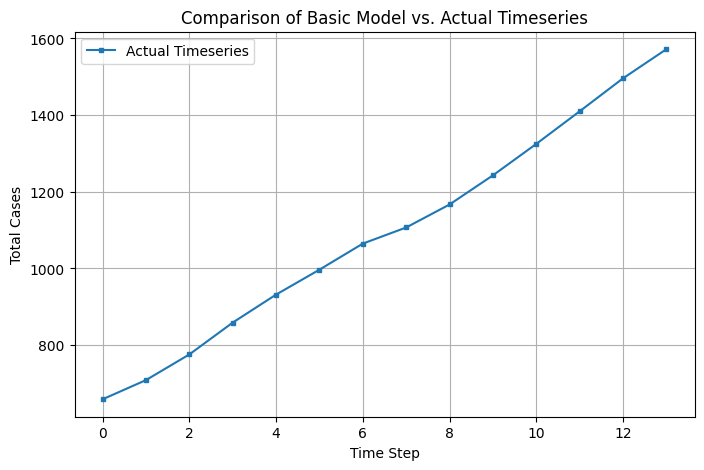

In [17]:
# Plot error for the whole city with basic method
extracted_sol = np.transpose(sol, (1, 2, 0))[2]

total_model_timeseries = np.sum(extracted_sol,axis=0)
total_timeseries = np.sum(all_station_timeseries,axis=0)
print(total_model_timeseries.shape,total_timeseries.shape)

# Plot the two time series against each other
plt.figure(figsize=(8, 5))
# plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_timeseries, label="Actual Timeseries", linestyle='-', marker='s', markersize=3)

# Labels and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Comparison of Basic Model vs. Actual Timeseries")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

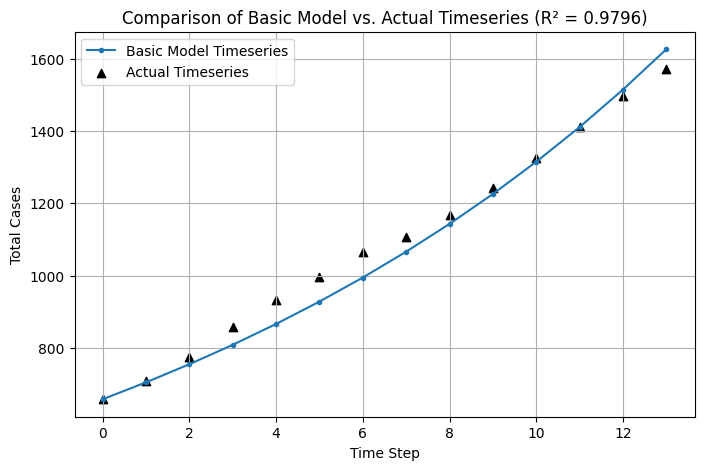

In [18]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(total_timeseries, total_model_timeseries)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.scatter(range(len(total_timeseries)),total_timeseries, label="Actual Timeseries", linestyle='-', marker='^', color='black')

plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title(f"Comparison of Basic Model vs. Actual Timeseries (R² = {r2:.4f})")
plt.legend()
plt.grid(True)
plt.show()


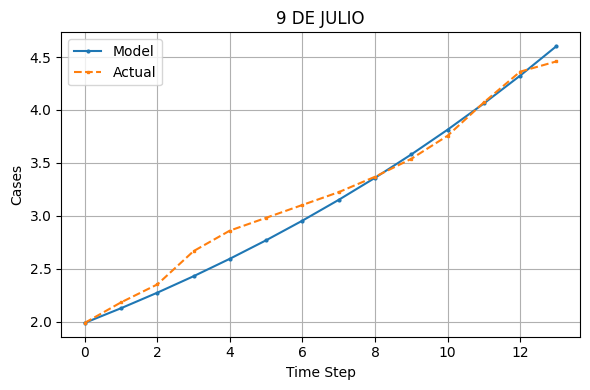

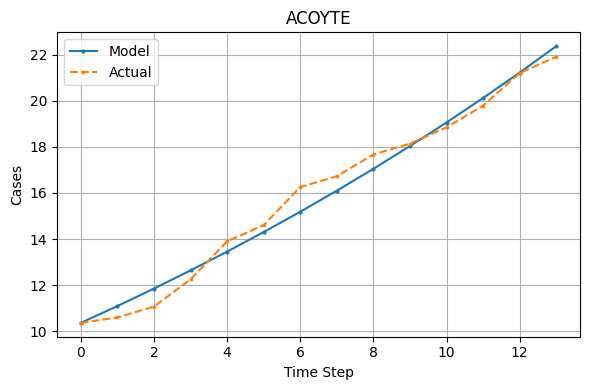

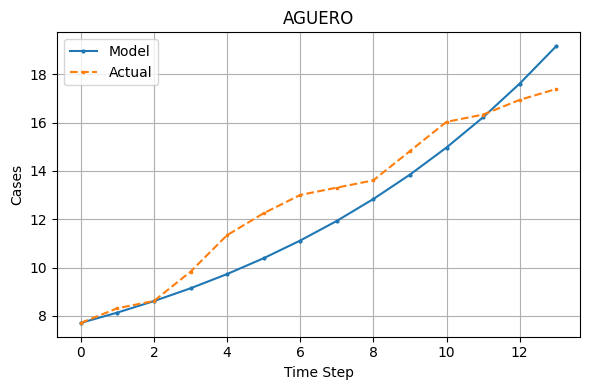

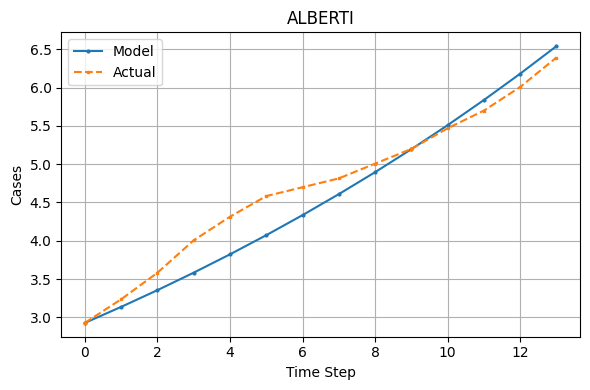

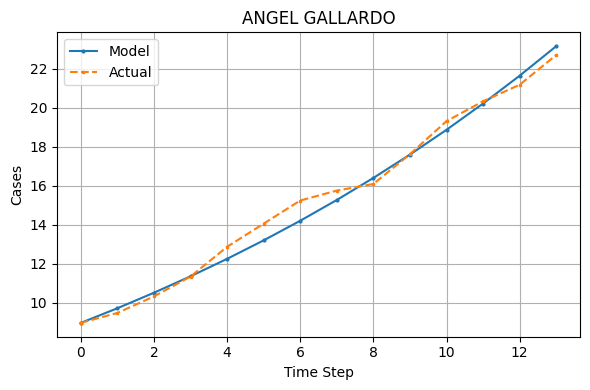

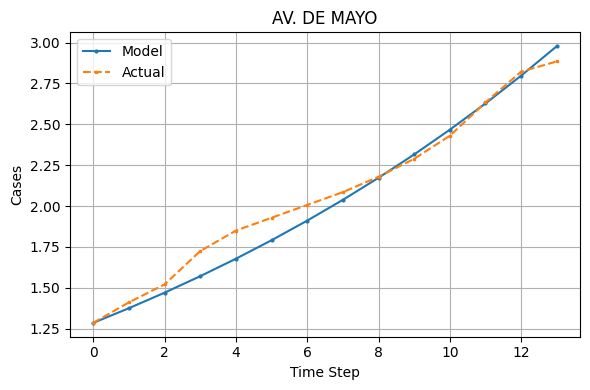

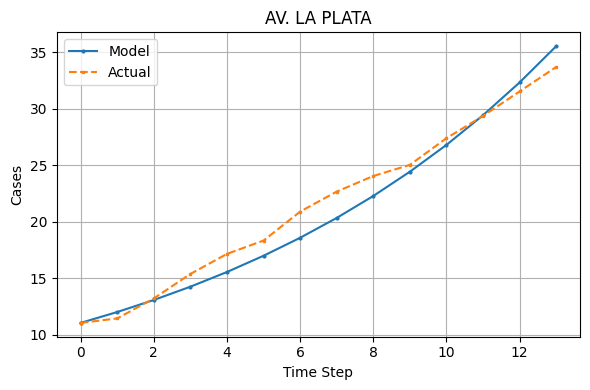

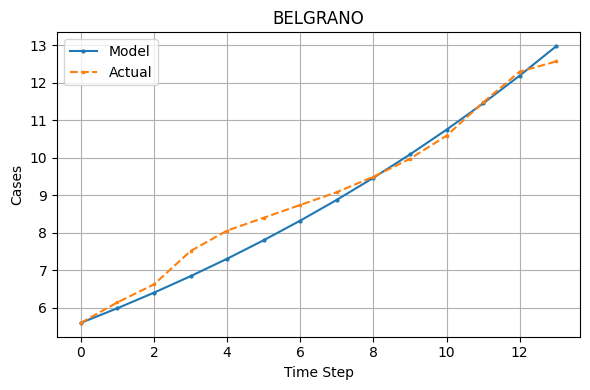

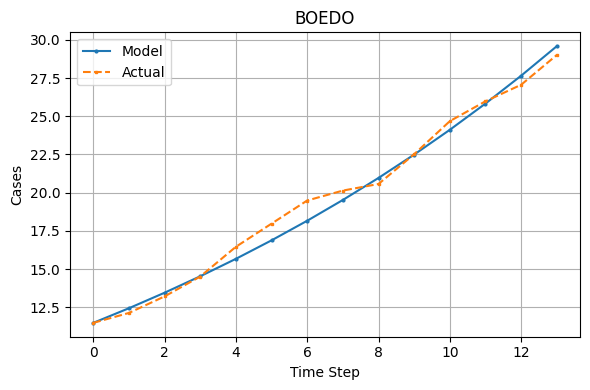

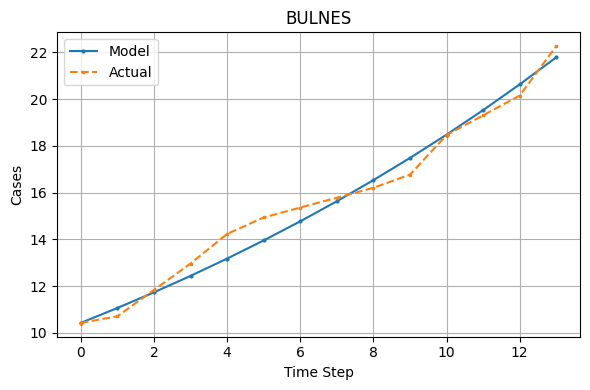

In [77]:
extracted_sol = np.transpose(sol, (1, 2, 0))[2]  # shape: (num_indices, num_timesteps)
num_indices = 10

for i in range(num_indices):
    model_ts = extracted_sol[i]
    actual_ts = all_station_timeseries[i]

    plt.figure(figsize=(6, 4))
    plt.plot(model_ts, label="Model", linestyle='-', marker='o', markersize=2)
    plt.plot(actual_ts, label="Actual", linestyle='--', marker='s', markersize=2)

    plt.xlabel("Time Step")
    plt.ylabel("Cases")
    plt.title(f"{station_list[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


(14, 6085)


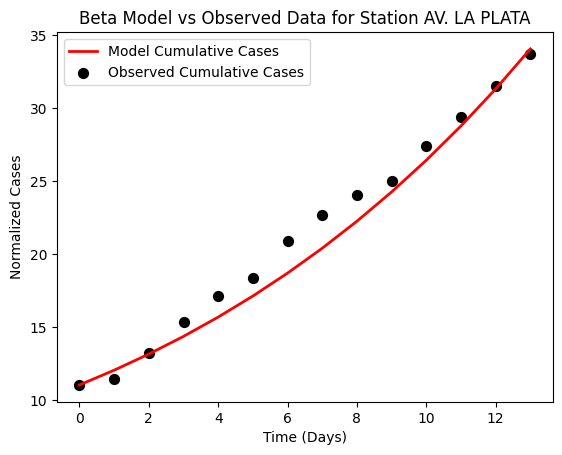

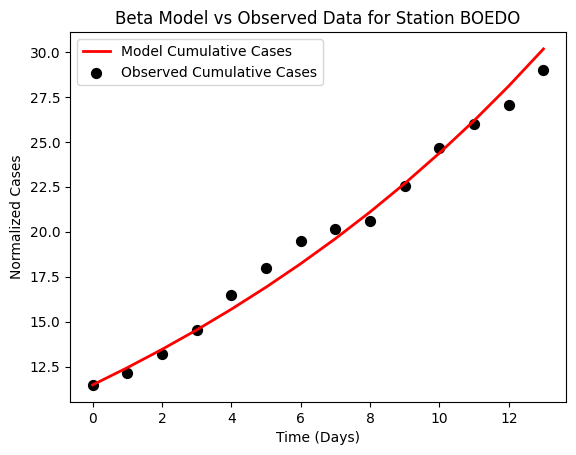

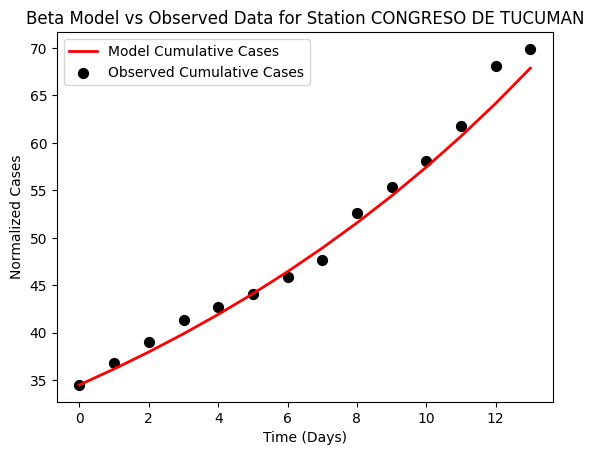

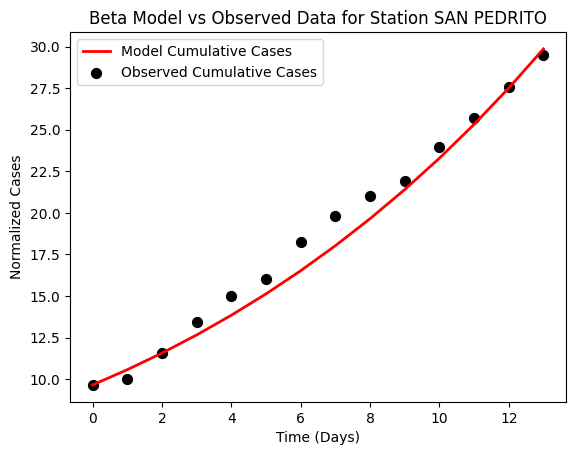

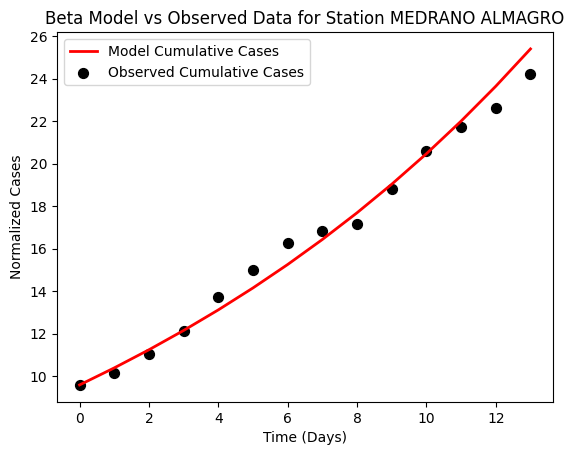

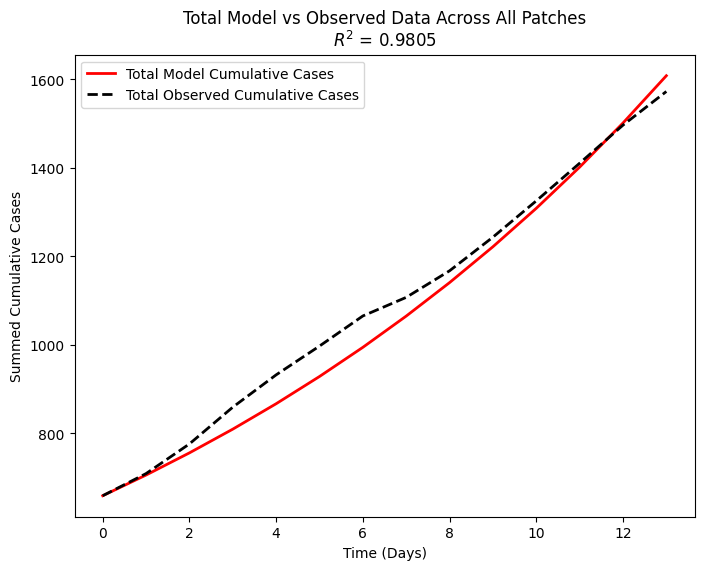

In [19]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)
        
def make_detailed_beta(short_beta):
    new_beta_0 = np.zeros(246)

    for i in range(78):
        new_beta_0[i] = short_beta[i]
    for i in range(246-78):
        new_beta_0[i+78] = short_beta[-1]
    return np.array(new_beta_0)

def expand_detailed_beta(detailed_beta):
    big_beta = np.zeros(6084)
    home_betas = detailed_beta[:78]
    travel_betas = detailed_beta[78:]
    big_beta[home_patches] = home_betas
    big_beta[travel_patches] = travel_betas
    
    return big_beta

# Load best beta values
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    print(data.shape)

    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = short_pop_vector
    # test_data = I_sum_model / normalizer[:, np.newaxis]
    # real_data = raw_real_data / normalizer[:, np.newaxis]
    test_data = I_sum_model
    real_data = raw_real_data
    
    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:5]
    

    # Plot results
    for i in top_10_indices:
        plt.figure()
        plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        plt.xlabel('Time (Days)')
        plt.ylabel('Normalized Cases')
        plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        plt.legend()
        plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    plt.figure(figsize=(8,6))
    plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    plt.xlabel('Time (Days)')
    plt.ylabel('Summed Cumulative Cases')
    from sklearn.metrics import r2_score
    r2 = r2_score(summed_real, summed_model)
    plt.title(f'Total Model vs Observed Data Across All Patches\n$R^2$ = {r2:.4f}')

    plt.legend()
    plt.show()

        
    return np.array(solution),params

solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [10]:
import numpy as np
import pandas as pd
from collections import defaultdict

def rank_boroughs_by_infection(station_list, station_borough_list, extracted_sol, short_pop_vector):
    # Map each station to its borough
    borough_map = {station: borough for station, borough in zip(station_list, station_borough_list)}
    
    # Initialize borough time series and population trackers
    borough_time_series = defaultdict(lambda: np.zeros(extracted_sol.shape[1]))
    borough_populations = defaultdict(int)
    
    for i, station in enumerate(station_list):
        borough = borough_map[station]
        borough_time_series[borough] += extracted_sol[i]
        borough_populations[borough] += short_pop_vector[i]
    
    # Compute proportion infected time series for each borough
    borough_proportions = {
        borough: time_series / borough_populations[borough]
        for borough, time_series in borough_time_series.items()
    }
    
    # Create DataFrame and sort columns by highest infected proportion at each time step
    df = pd.DataFrame(borough_proportions)
    ranking_df = df.rank(axis=1, ascending=False, method='min')

    return df, ranking_df  # proportions, and rankings at each time step

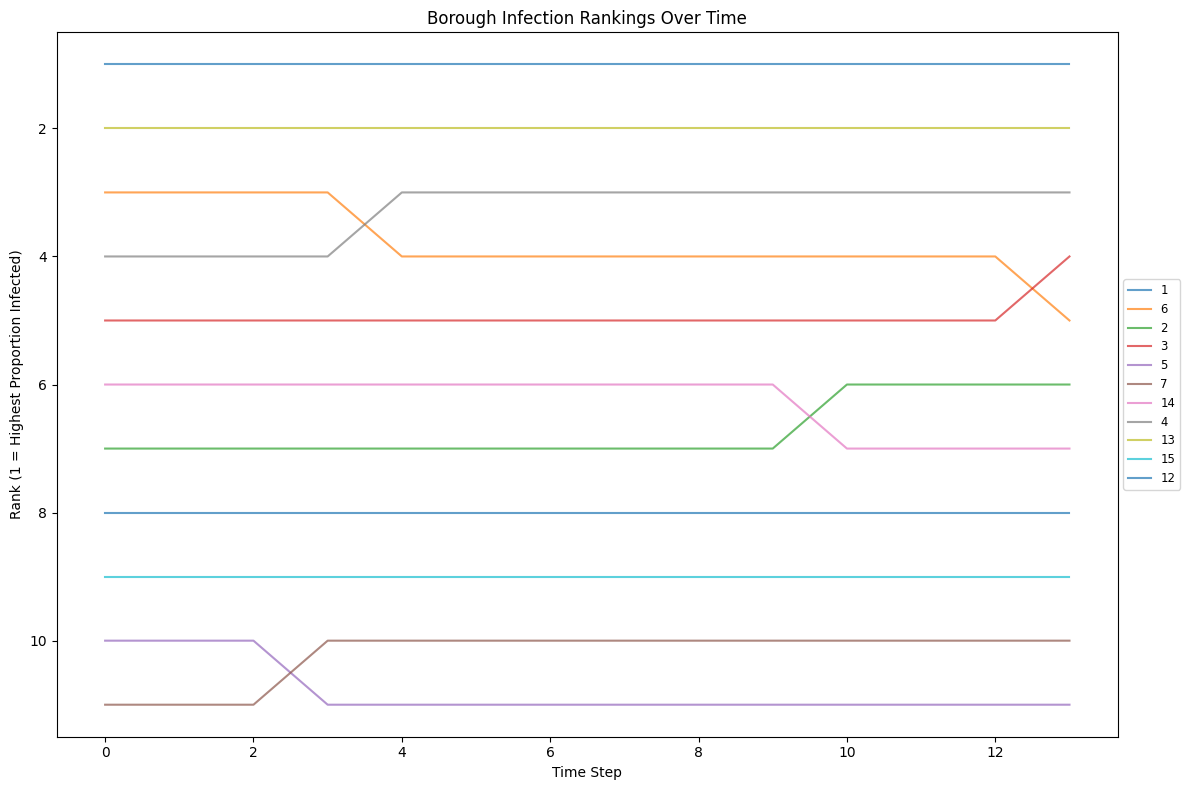

In [80]:
borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
    station_list, station_borough_list, extracted_sol, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_sir.columns:
    plt.plot(borough_ranks_sir.index, borough_ranks_sir[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

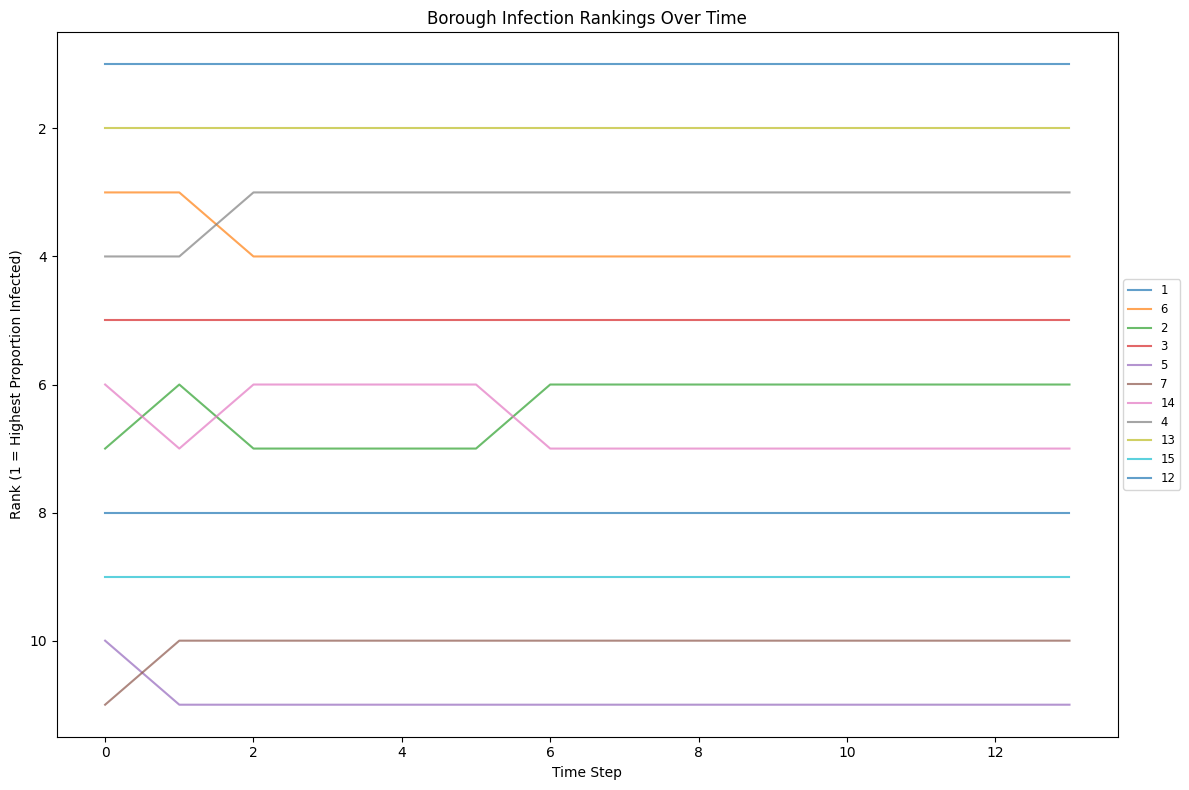

In [81]:
borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
    station_list, station_borough_list, all_station_timeseries, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_data.columns:
    plt.plot(borough_ranks_data.index, borough_ranks_data[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

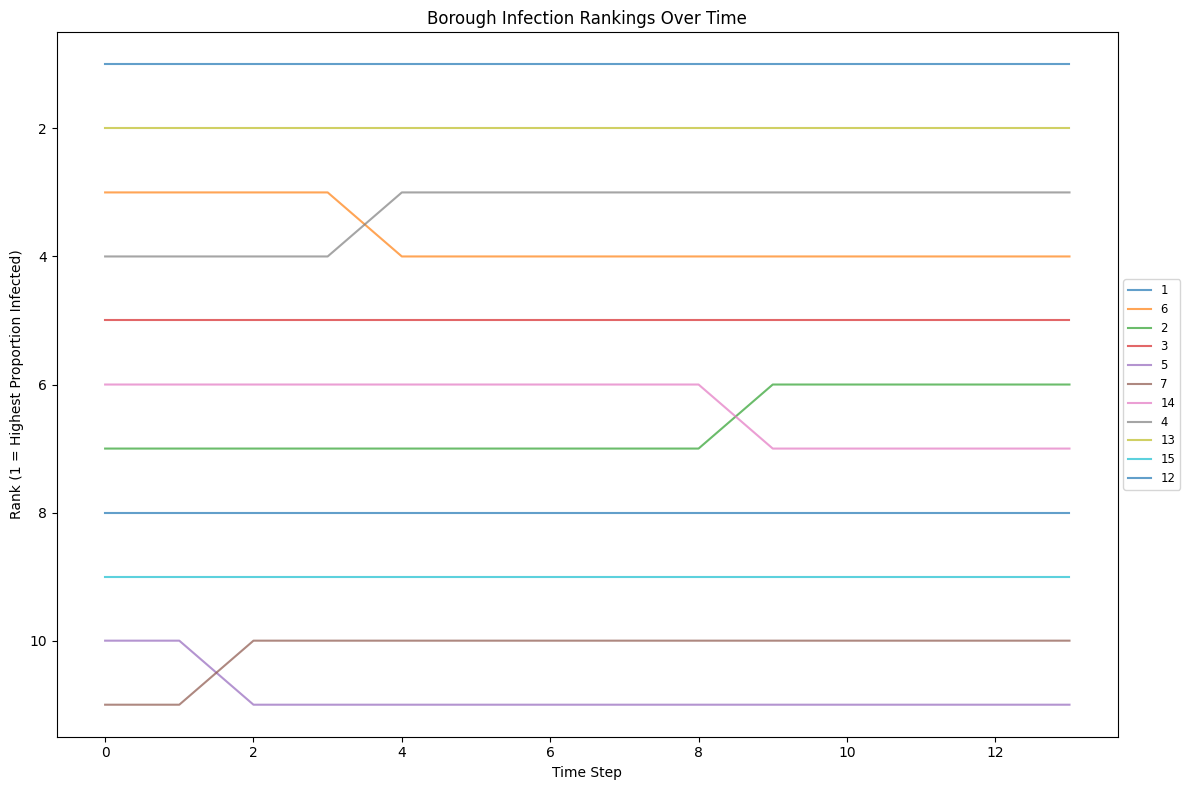

In [82]:
model_solution = solution_model[2][home_patches]

borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
    station_list, station_borough_list, model_solution, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_model.columns:
    plt.plot(borough_ranks_model.index, borough_ranks_model[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [83]:
borough_ranks_model

,1,6,2,3,5,7,14,4,13,15,12
0,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
1,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
2,8.0,3.0,7.0,5.0,11.0,10.0,6.0,4.0,2.0,9.0,1.0
3,8.0,3.0,7.0,5.0,11.0,10.0,6.0,4.0,2.0,9.0,1.0
4,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
5,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
6,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
7,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
8,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
9,8.0,4.0,6.0,5.0,11.0,10.0,7.0,3.0,2.0,9.0,1.0


In [84]:
borough_ranks_data

,1,6,2,3,5,7,14,4,13,15,12
0,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
1,8.0,3.0,6.0,5.0,11.0,10.0,7.0,4.0,2.0,9.0,1.0
2,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
3,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
4,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
5,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
6,8.0,4.0,6.0,5.0,11.0,10.0,7.0,3.0,2.0,9.0,1.0
7,8.0,4.0,6.0,5.0,11.0,10.0,7.0,3.0,2.0,9.0,1.0
8,8.0,4.0,6.0,5.0,11.0,10.0,7.0,3.0,2.0,9.0,1.0
9,8.0,4.0,6.0,5.0,11.0,10.0,7.0,3.0,2.0,9.0,1.0


In [85]:
borough_ranks_sir

,1,6,2,3,5,7,14,4,13,15,12
0,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
1,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
2,8.0,3.0,7.0,5.0,10.0,11.0,6.0,4.0,2.0,9.0,1.0
3,8.0,3.0,7.0,5.0,11.0,10.0,6.0,4.0,2.0,9.0,1.0
4,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
5,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
6,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
7,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
8,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0
9,8.0,4.0,7.0,5.0,11.0,10.0,6.0,3.0,2.0,9.0,1.0


In [86]:
np.array(borough_ranks_data)

array([[ 8.,  3.,  7.,  5., 10., 11.,  6.,  4.,  2.,  9.,  1.],
       [ 8.,  3.,  6.,  5., 11., 10.,  7.,  4.,  2.,  9.,  1.],
       [ 8.,  4.,  7.,  5., 11., 10.,  6.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  7.,  5., 11., 10.,  6.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  7.,  5., 11., 10.,  6.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  7.,  5., 11., 10.,  6.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.],
       [ 8.,  4.,  6.,  5., 11., 10.,  7.,  3.,  2.,  9.,  1.]])

In [12]:
from scipy.stats import kendalltau

true = np.array(borough_ranks_data)      # bob, billy, david
model1 = np.array(borough_ranks_sir)    # billy, bob, david
model2 = np.array(borough_ranks_model)    # david, billy, bob

tau1, _ = kendalltau(true, model1)
tau2, _ = kendalltau(true, model2)

print(tau1, tau2)  # higher value = better ranking
import numpy as np
import pandas as pd
from collections import defaultdict

def rank_boroughs_by_infection(station_list, station_borough_list, extracted_sol, short_pop_vector):
    # Map each station to its borough
    borough_map = {station: borough for station, borough in zip(station_list, station_borough_list)}
    
    # Initialize borough time series and population trackers
    borough_time_series = defaultdict(lambda: np.zeros(extracted_sol.shape[1]))
    borough_populations = defaultdict(int)
    
    for i, station in enumerate(station_list):
        borough = borough_map[station]
        borough_time_series[borough] += extracted_sol[i]
        borough_populations[borough] += short_pop_vector[i]
    
    # Compute proportion infected time series for each borough
    borough_proportions = {
        borough: time_series / borough_populations[borough]
        for borough, time_series in borough_time_series.items()
    }
    
    # Create DataFrame and sort columns by highest infected proportion at each time step
    df = pd.DataFrame(borough_proportions)
    ranking_df = df.rank(axis=1, ascending=False, method='min')

    return df, ranking_df  # proportions, and rankings at each time step


NameError: name 'borough_ranks_data' is not defined

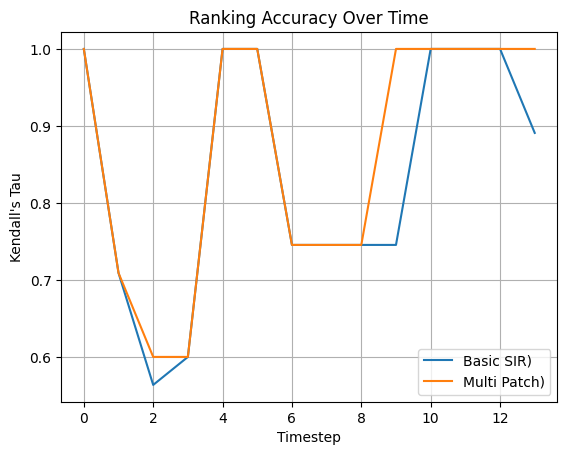

In [129]:
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

# Assuming shapes: (timesteps, boroughs)
true = np.array(borough_ranks_data)
model1 = np.array(borough_ranks_sir)
model2 = np.array(borough_ranks_model)

tau_scores_1 = []
tau_scores_2 = []

for t in range(true.shape[0]):
    # Get values at timestep t
    true_t = true[t]
    model1_t = model1[t]
    model2_t = model2[t]

    # Get ranks (higher value = higher rank)
    true_rank = np.argsort(-true_t)
    model1_rank = np.argsort(-model1_t)
    model2_rank = np.argsort(-model2_t)

    tau1, _ = kendalltau(true_rank, model1_rank)
    tau2, _ = kendalltau(true_rank, model2_rank)

    tau_scores_1.append(tau1)
    tau_scores_2.append(tau2)

# Plot
plt.plot(tau_scores_1, label='Basic SIR)')
plt.plot(tau_scores_2, label='Multi Patch)')
plt.xlabel('Timestep')
plt.ylabel("Kendall's Tau")
plt.title("Ranking Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
all_station_timeseries = all_station_timeseries_old.copy()

/tmp/ipykernel_1661072/3350508627.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


46


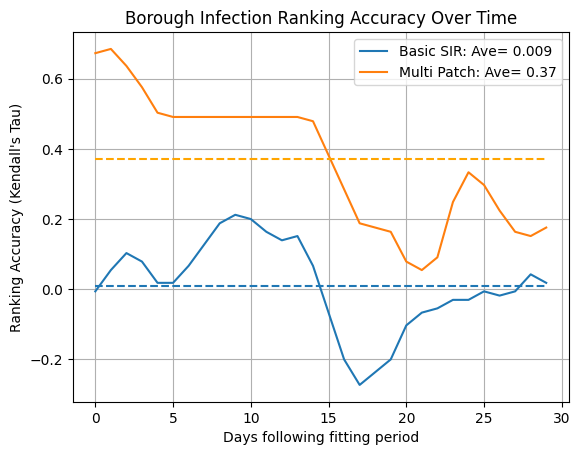

In [97]:
total_pop = np.sum(pop_vector)

def make_taus(timesteps):
    day_range = timesteps
    def expand_array(short_array):
        long_array = np.zeros(6084)  # Create a zero array of the desired size

        # Assign values at the correct positions
        long_array[np.arange(78) * (78 + 1)] = short_array
        return long_array

    def expand_timeseries(short_timeseries):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((day_range,6084))
        for i in range(day_range):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries


    def compress_timeseries(long_timeseries):
        compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape

        for i in range(day_range):
            compressed[i] = compress_array(long_timeseries[i])

        return compressed.T  # Transpose back to match original input shape

    def compress_array(long_array):
        return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


    def expand_betas(short_betas,long_length):

        long_betas = np.zeros(long_length)
        index = 0
        for i in valid_patch_indices:
            long_betas[i] = short_betas[index]
            index += 1

        return long_betas



    with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
        pop_dict = pickle.load(file)

    # Assuming pop_dict is a pandas DataFrame
    pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
    pop_dict = dict(sorted(pop_dict.items()))

    # Extract values in order
    short_pop_vector = np.array(list(pop_dict.values()))

    pop_vector = expand_array(short_pop_vector)

    borough_list = np.array(range(15))+1

    with open("ba_big station list.pkl", "rb") as file:
        station_list = pickle.load(file)

    with open("station_comuna_dict.pkl", 'rb') as f:
        station_comuna_dict = pickle.load(f)

    station_borough_list = list(station_comuna_dict.values())

    with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
        props_dict = pickle.load(f)

    with open("BA_Covid_Data.pkl", 'rb') as f:
        covid_df = pickle.load(f)

    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure datetime and sort
    covid_df['date'] = pd.to_datetime(covid_df['date'])
    covid_df = covid_df.sort_values(['comuna', 'date'])

    # Filter out comunas 8–11
    df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

    # Create full MultiIndex for relevant comunas and dates
    all_dates = pd.date_range('2020-01-01', '2020-05-31')
    comunas = df_filtered['comuna'].unique()
    multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

    # Reindex and interpolate daily_cases
    df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
    df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

    # Identify missing comuna on April 23
    existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
    interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
    missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
    value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

    # Estimate total_cases using previous day's value
    prev_total = covid_df[
        (covid_df['comuna'] == missing_comuna) &
        (covid_df['date'] == pd.Timestamp('2020-04-22'))
    ]['total_cases'].values[0]
    estimated_total = prev_total + value

    # Create and insert new row
    new_row = {
        'date': pd.Timestamp('2020-04-23'),
        'comuna': missing_comuna,
        'daily_cases': value,
        'total_cases': estimated_total
    }
    covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
    covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

    # --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

    # Isolate comuna 6.0 from April 2 on
    comuna_df = covid_df[
        (covid_df['comuna'] == 6.0) &
        (covid_df['date'] >= '2020-04-02')
    ].sort_values('date').copy()

    # Get first known total_cases to anchor cumulative sum
    anchor_total = comuna_df.iloc[0]['total_cases']

    # Compute cumulative daily cases
    comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
    comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

    # Update total_cases in original covid_df
    covid_df.loc[
        (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
        'total_cases'
    ] = comuna_df['adjusted_total'].values


    with open("ba_all_paths.pkl", 'rb') as f:
        all_paths = pickle.load(f)

    # with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
        # commuter_array = pickle.load(file)


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    def get_timeseries(station_name,covid_df,props_dict):

        current_borough = props_dict[station_name][0]

        # Filter data for the given area_name "Lambeth" and within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] <= "2020-08-07") & 
            (covid_df['comuna'] == current_borough)
        ]

        # Find the earliest date where total_cases is nonzero
        # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
        earliest_nonzero_date = "2020-07-23"

        # Filter again using the adjusted start date
        filtered_df = filtered_df[
            (filtered_df['date'] >= earliest_nonzero_date) & 
            (filtered_df['date'] <= "2020-08-07")
        ]

        borough_timeseries = np.array(list(filtered_df['total_cases']))

        station_timeseries = props_dict[station_name][1]*borough_timeseries


        return station_timeseries

    def get_timeseries_with_five(station_name, covid_df, props_dict):
        current_borough = props_dict[station_name][0]

        # Define the start and end dates
        earliest_nonzero_date = pd.to_datetime("2020-04-05")
        end_date = earliest_nonzero_date + pd.Timedelta(days=timesteps - 1)
        five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

        # Filter data for the given borough within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] >= earliest_nonzero_date) & 
            (covid_df['date'] <= end_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        borough_timeseries = np.array(filtered_df['total_cases'])
        station_timeseries = props_dict[station_name][1] * borough_timeseries

        # Get new cases in the 5 days before the earliest nonzero date
        previous_df = covid_df[
            (covid_df['date'] >= five_days_before) & 
            (covid_df['date'] < earliest_nonzero_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

        return station_timeseries, total_new_cases_prev_5_days


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    all_station_timeseries = []
    all_new_cases_prev_5_days = []
    for i in range(len(station_list)):
        timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
        all_station_timeseries.append(timeseries[0])
        all_new_cases_prev_5_days.append(timeseries[1])


    all_station_timeseries = np.array(all_station_timeseries)
    day_range = all_station_timeseries[0].shape[0]
    print(day_range)

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    # Define main control panel functions

    # with open("London new Nj.pkl", "rb") as file:
        # Nj = pickle.load(file)

    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)

    # Load files
    with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
        sparse_p = pickle.load(file)

    p_matrix = sparse_p.toarray()
    Nj = pop_vector @ p_matrix

    Nj_safe = Nj.copy()
    Nj_safe[Nj_safe == 0] = 1
    Nj = Nj_safe.copy()

    with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
        valid_patches = pickle.load(f)

    with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
        valid_patch_indices = pickle.load(f)

    np.set_printoptions(suppress=True)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    gamma = 1/5

    with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
        best_beta_yet = pickle.load(file)

    home_betas = best_beta_yet[:78]

    current_cases,cum_cases



    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)
        
    def SIR(y,beta,gamma):
        S,I,I_total = y
        N = total_pop
        dSdt = -beta*S*I/N
        dIdt = beta*S*I/N - gamma*I
        dItotaldt = beta*S*I/N
        return np.array([dSdt,dIdt,dItotaldt])

    N = total_pop
    I0 = all_station_timeseries.T[0]
    I0_total = all_station_timeseries.T[0]
    S0 = N-I0

    beta = beta_array.copy()
    gamma = 1/5

    timesteps = all_station_timeseries.shape[1]
    sol = np.zeros([timesteps,3,78])
    sol[0] = np.array([S0,I0,I0_total])

    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)
        
    extracted_sol = np.transpose(sol, (1, 2, 0))[1]

    total_model_timeseries = np.sum(extracted_sol,axis=0)
    total_timeseries = np.sum(all_station_timeseries,axis=0)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    def make_detailed_beta(short_beta):
        new_beta_0 = np.zeros(246)

        for i in range(78):
            new_beta_0[i] = short_beta[i]
        for i in range(246-78):
            new_beta_0[i+78] = short_beta[-1]
        return np.array(new_beta_0)

    def expand_detailed_beta(detailed_beta):
        big_beta = np.zeros(6084)
        home_betas = detailed_beta[:78]
        travel_betas = detailed_beta[78:]
        big_beta[home_patches] = home_betas
        big_beta[travel_patches] = travel_betas

        return big_beta

    # Load best beta values
    with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
        best_beta_yet_0 = pickle.load(file)

    def expand_concise_betas(home_patches,travel_patches,concise_beta):
        long_beta = np.zeros(6084)
        for i in range(78):
            long_beta[home_patches[i]] = concise_beta[i]
        long_beta[travel_patches] = concise_beta[-1]

        return long_beta

    best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

    def plot_best_beta_vs_data(full_timeseries, pop_dict):
        """
        Extracts the relevant data, runs the SIR model with best_beta_yet, 
        and plots the beta values against the corresponding observed data.

        Parameters:
            full_timeseries (array-like): The full dataset of observed values.
            pop_dict (dict): Dictionary mapping population values.
        """
         # Load data
        working_timeseries = expand_timeseries(full_timeseries)

        short_pop_vector = np.array(list(pop_dict.values()))
        pop_vector = expand_array(short_pop_vector)

        day_list = np.arange(day_range)  # There are day_range days

        # Stack so each row is [day_index, corresponding 9 values]
        data = np.column_stack((day_list[:, None], working_timeseries))

        tspan = data[:, 0]
        timespan = tspan.shape[0] - 1
        gamma = 1 / 5
        


        I0 = expand_array(current_cases)
        S0 = pop_vector - I0
        I_total_0 = cum_cases

        params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
        solution = run_model_London(params)
        y = solution[1]

        I_sum_model = compress_timeseries(y.T)
        raw_real_data = compress_timeseries(data.T[1:].T)
        normalizer = compress_array(pop_vector)[:, np.newaxis]
        test_data = I_sum_model / normalizer
        real_data = raw_real_data / normalizer

        # Get indices of the 10 stations with the highest total populations
        top_10_indices = np.argsort(-short_pop_vector)[:10]


        return np.array(solution),params

    solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
    
    borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
        station_list, station_borough_list, extracted_sol, short_pop_vector
    )
    
    borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
        station_list, station_borough_list, all_station_timeseries, short_pop_vector
    )
    
    model_solution = solution_model[2][home_patches]

    borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
        station_list, station_borough_list, model_solution, short_pop_vector
    )
    # Assuming shapes: (timesteps, boroughs)
    true = np.array(borough_ranks_data)
    model1 = np.array(borough_ranks_sir)
    model2 = np.array(borough_ranks_model)

    tau_scores_1 = []
    tau_scores_2 = []
    

    for t in range(14, true.shape[0]):
        # Get values at timestep t
        true_t = true[t]
        model1_t = model1[t]
        model2_t = model2[t]

        # Get ranks (higher value = higher rank)
        true_rank = np.argsort(-true_t)
        model1_rank = np.argsort(-model1_t)
        model2_rank = np.argsort(-model2_t)

        tau1, _ = kendalltau(true_rank, model1_rank)
        tau2, _ = kendalltau(true_rank, model2_rank)

        tau_scores_1.append(tau1)
        tau_scores_2.append(tau2)
        
    def moving_average(x, w=3):
        return np.convolve(x, np.ones(w)/w, mode='valid')

    smoothed_tau_1 = moving_average(tau_scores_1, w=3)
    smoothed_tau_2 = moving_average(tau_scores_2, w=3)


    # Plot
    plt.plot(smoothed_tau_1, label=f'Basic SIR: Ave= {np.round(np.average(tau_scores_1),3)}')
    plt.plot(smoothed_tau_2, label=f'Multi Patch: Ave= {np.round(np.average(tau_scores_2),3)}')
    # Horizontal average lines (same length as original, so align correctly)
    plt.hlines(np.average(tau_scores_1), xmin=0, xmax=len(smoothed_tau_1)-1, 
               linestyles='dashed')

    plt.hlines(np.average(tau_scores_2), xmin=0, xmax=len(smoothed_tau_2)-1, 
               linestyles='dashed', colors='orange')

    plt.xlabel('Days following fitting period')
    plt.ylabel("Ranking Accuracy (Kendall's Tau)")
    plt.title("Borough Infection Ranking Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    
make_taus(46)




/tmp/ipykernel_1872065/4187135006.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


46


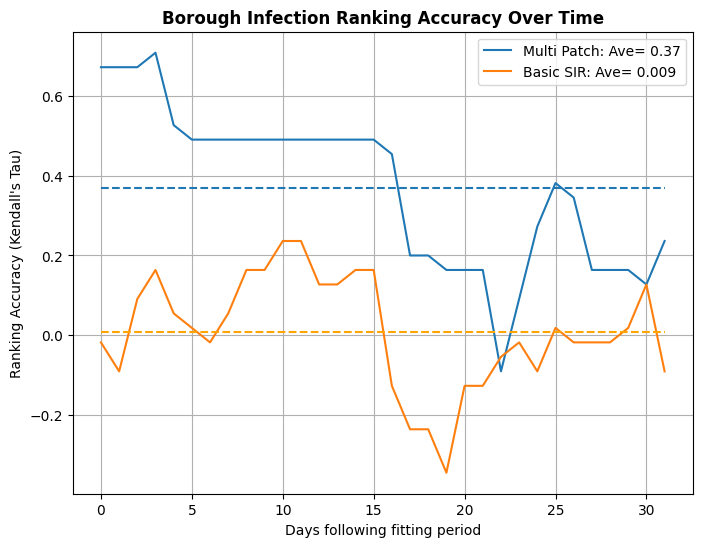

In [17]:
def make_taus(timesteps):
    day_range = timesteps
    def expand_array(short_array):
        long_array = np.zeros(6084)  # Create a zero array of the desired size

        # Assign values at the correct positions
        long_array[np.arange(78) * (78 + 1)] = short_array
        return long_array

    def expand_timeseries(short_timeseries):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((day_range,6084))
        for i in range(day_range):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries


    def compress_timeseries(long_timeseries):
        compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape

        for i in range(day_range):
            compressed[i] = compress_array(long_timeseries[i])

        return compressed.T  # Transpose back to match original input shape

    def compress_array(long_array):
        return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


    def expand_betas(short_betas,long_length):

        long_betas = np.zeros(long_length)
        index = 0
        for i in valid_patch_indices:
            long_betas[i] = short_betas[index]
            index += 1

        return long_betas



    with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
        pop_dict = pickle.load(file)
        
        

    # Assuming pop_dict is a pandas DataFrame
    pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
    pop_dict = dict(sorted(pop_dict.items()))


    # Extract values in order
    short_pop_vector = np.array(list(pop_dict.values()))

    pop_vector = expand_array(short_pop_vector)

    borough_list = np.array(range(15))+1

    with open("ba_big station list.pkl", "rb") as file:
        station_list = pickle.load(file)

    with open("station_comuna_dict.pkl", 'rb') as f:
        station_comuna_dict = pickle.load(f)

    station_borough_list = list(station_comuna_dict.values())

    with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
        props_dict = pickle.load(f)

    with open("BA_Covid_Data.pkl", 'rb') as f:
        covid_df = pickle.load(f)

    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure datetime and sort
    covid_df['date'] = pd.to_datetime(covid_df['date'])
    covid_df = covid_df.sort_values(['comuna', 'date'])

    # Filter out comunas 8–11
    df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

    # Create full MultiIndex for relevant comunas and dates
    all_dates = pd.date_range('2020-01-01', '2020-05-31')
    comunas = df_filtered['comuna'].unique()
    multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

    # Reindex and interpolate daily_cases
    df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
    df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

    # Identify missing comuna on April 23
    existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
    interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
    missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
    value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

    # Estimate total_cases using previous day's value
    prev_total = covid_df[
        (covid_df['comuna'] == missing_comuna) &
        (covid_df['date'] == pd.Timestamp('2020-04-22'))
    ]['total_cases'].values[0]
    estimated_total = prev_total + value

    # Create and insert new row
    new_row = {
        'date': pd.Timestamp('2020-04-23'),
        'comuna': missing_comuna,
        'daily_cases': value,
        'total_cases': estimated_total
    }
    covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
    covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

    # --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

    # Isolate comuna 6.0 from April 2 on
    comuna_df = covid_df[
        (covid_df['comuna'] == 6.0) &
        (covid_df['date'] >= '2020-04-02')
    ].sort_values('date').copy()

    # Get first known total_cases to anchor cumulative sum
    anchor_total = comuna_df.iloc[0]['total_cases']

    # Compute cumulative daily cases
    comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
    comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

    # Update total_cases in original covid_df
    covid_df.loc[
        (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
        'total_cases'
    ] = comuna_df['adjusted_total'].values


    with open("ba_all_paths.pkl", 'rb') as f:
        all_paths = pickle.load(f)

    # with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
        # commuter_array = pickle.load(file)


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    def get_timeseries(station_name,covid_df,props_dict):

        current_borough = props_dict[station_name][0]

        # Filter data for the given area_name "Lambeth" and within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] <= "2020-08-07") & 
            (covid_df['comuna'] == current_borough)
        ]

        # Find the earliest date where total_cases is nonzero
        # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
        earliest_nonzero_date = "2020-07-23"

        # Filter again using the adjusted start date
        filtered_df = filtered_df[
            (filtered_df['date'] >= earliest_nonzero_date) & 
            (filtered_df['date'] <= "2020-08-07")
        ]

        borough_timeseries = np.array(list(filtered_df['total_cases']))

        station_timeseries = props_dict[station_name][1]*borough_timeseries


        return station_timeseries

    def get_timeseries_with_five(station_name, covid_df, props_dict):
        current_borough = props_dict[station_name][0]

        # Define the start and end dates
        earliest_nonzero_date = pd.to_datetime("2020-04-05")
        end_date = earliest_nonzero_date + pd.Timedelta(days=timesteps - 1)
        five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

        # Filter data for the given borough within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] >= earliest_nonzero_date) & 
            (covid_df['date'] <= end_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        borough_timeseries = np.array(filtered_df['total_cases'])
        station_timeseries = props_dict[station_name][1] * borough_timeseries

        # Get new cases in the 5 days before the earliest nonzero date
        previous_df = covid_df[
            (covid_df['date'] >= five_days_before) & 
            (covid_df['date'] < earliest_nonzero_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

        return station_timeseries, total_new_cases_prev_5_days


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    all_station_timeseries = []
    all_new_cases_prev_5_days = []
    for i in range(len(station_list)):
        timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
        all_station_timeseries.append(timeseries[0])
        all_new_cases_prev_5_days.append(timeseries[1])


    all_station_timeseries = np.array(all_station_timeseries)
    day_range = all_station_timeseries[0].shape[0]
    print(day_range)

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    # Define main control panel functions

    # with open("London new Nj.pkl", "rb") as file:
        # Nj = pickle.load(file)

    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)

    # Load files
    with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
        sparse_p = pickle.load(file)

    p_matrix = sparse_p.toarray()
    Nj = pop_vector @ p_matrix

    Nj_safe = Nj.copy()
    Nj_safe[Nj_safe == 0] = 1
    Nj = Nj_safe.copy()

    with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
        valid_patches = pickle.load(f)

    with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
        valid_patch_indices = pickle.load(f)

    np.set_printoptions(suppress=True)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    gamma = 1/5

    with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
        best_beta_yet = pickle.load(file)

    home_betas = best_beta_yet[:78]

    current_cases,cum_cases



    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)
        
    def SIR(y,beta,gamma):
        S,I,I_total = y
        N = total_pop
        dSdt = -beta*S*I/N
        dIdt = beta*S*I/N - gamma*I
        dItotaldt = beta*S*I/N
        return np.array([dSdt,dIdt,dItotaldt])

    N = total_pop
    I0 = all_station_timeseries.T[0]
    I0_total = all_station_timeseries.T[0]
    S0 = N-I0

    beta = beta_array.copy()
    gamma = 1/5

    timesteps = all_station_timeseries.shape[1]
    sol = np.zeros([timesteps,3,78])
    sol[0] = np.array([S0,I0,I0_total])

    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)
        
    extracted_sol = np.transpose(sol, (1, 2, 0))[1]

    total_model_timeseries = np.sum(extracted_sol,axis=0)
    total_timeseries = np.sum(all_station_timeseries,axis=0)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    def make_detailed_beta(short_beta):
        new_beta_0 = np.zeros(246)

        for i in range(78):
            new_beta_0[i] = short_beta[i]
        for i in range(246-78):
            new_beta_0[i+78] = short_beta[-1]
        return np.array(new_beta_0)

    def expand_detailed_beta(detailed_beta):
        big_beta = np.zeros(6084)
        home_betas = detailed_beta[:78]
        travel_betas = detailed_beta[78:]
        big_beta[home_patches] = home_betas
        big_beta[travel_patches] = travel_betas

        return big_beta

    # Load best beta values
    with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
        best_beta_yet_0 = pickle.load(file)

    def expand_concise_betas(home_patches,travel_patches,concise_beta):
        long_beta = np.zeros(6084)
        for i in range(78):
            long_beta[home_patches[i]] = concise_beta[i]
        long_beta[travel_patches] = concise_beta[-1]

        return long_beta

    best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

    def plot_best_beta_vs_data(full_timeseries, pop_dict):
        """
        Extracts the relevant data, runs the SIR model with best_beta_yet, 
        and plots the beta values against the corresponding observed data.

        Parameters:
            full_timeseries (array-like): The full dataset of observed values.
            pop_dict (dict): Dictionary mapping population values.
        """
         # Load data
        working_timeseries = expand_timeseries(full_timeseries)

        short_pop_vector = np.array(list(pop_dict.values()))
        pop_vector = expand_array(short_pop_vector)

        day_list = np.arange(day_range)  # There are day_range days

        # Stack so each row is [day_index, corresponding 9 values]
        data = np.column_stack((day_list[:, None], working_timeseries))

        tspan = data[:, 0]
        timespan = tspan.shape[0] - 1
        gamma = 1 / 5
        


        I0 = expand_array(current_cases)
        S0 = pop_vector - I0
        I_total_0 = cum_cases

        params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
        solution = run_model_London(params)
        y = solution[1]

        I_sum_model = compress_timeseries(y.T)
        raw_real_data = compress_timeseries(data.T[1:].T)
        normalizer = compress_array(pop_vector)[:, np.newaxis]
        test_data = I_sum_model / normalizer
        real_data = raw_real_data / normalizer

        # Get indices of the 10 stations with the highest total populations
        top_10_indices = np.argsort(-short_pop_vector)[:10]


        return np.array(solution),params

    solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
    
    borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
        station_list, station_borough_list, extracted_sol, short_pop_vector
    )
    
    borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
        station_list, station_borough_list, all_station_timeseries, short_pop_vector
    )
    
    model_solution = solution_model[2][home_patches]

    borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
        station_list, station_borough_list, model_solution, short_pop_vector
    )
    # Assuming shapes: (timesteps, boroughs)
    true = np.array(borough_ranks_data)
    model1 = np.array(borough_ranks_sir)
    model2 = np.array(borough_ranks_model)

    tau_scores_1 = []
    tau_scores_2 = []
    

    for t in range(14, true.shape[0]):
        # Get values at timestep t
        true_t = true[t]
        model1_t = model1[t]
        model2_t = model2[t]

        # Get ranks (higher value = higher rank)
        true_rank = np.argsort(-true_t)
        model1_rank = np.argsort(-model1_t)
        model2_rank = np.argsort(-model2_t)

        tau1, _ = kendalltau(true_rank, model1_rank)
        tau2, _ = kendalltau(true_rank, model2_rank)

        tau_scores_1.append(tau1)
        tau_scores_2.append(tau2)
        
    def moving_average(x, w=1):
        return np.convolve(x, np.ones(w)/w, mode='valid')

    smoothed_tau_1 = moving_average(tau_scores_1, w=1)
    smoothed_tau_2 = moving_average(tau_scores_2, w=1)
    
    plt.figure(figsize=(8,6))

    # Plot
    plt.plot(smoothed_tau_2, label=f'Multi Patch: Ave= {np.round(np.average(tau_scores_2),3)}')
    plt.plot(smoothed_tau_1, label=f'Basic SIR: Ave= {np.round(np.average(tau_scores_1),3)}')
    # Horizontal average lines (same length as original, so align correctly)
    plt.hlines(np.average(tau_scores_2), xmin=0, xmax=len(smoothed_tau_2)-1, 
               linestyles='dashed')
    plt.hlines(np.average(tau_scores_1), xmin=0, xmax=len(smoothed_tau_1)-1, 
               linestyles='dashed', color='orange')

    plt.xlabel('Days following fitting period')
    plt.ylabel("Ranking Accuracy (Kendall's Tau)")
    plt.title("Borough Infection Ranking Accuracy Over Time",fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

    
make_taus(46)

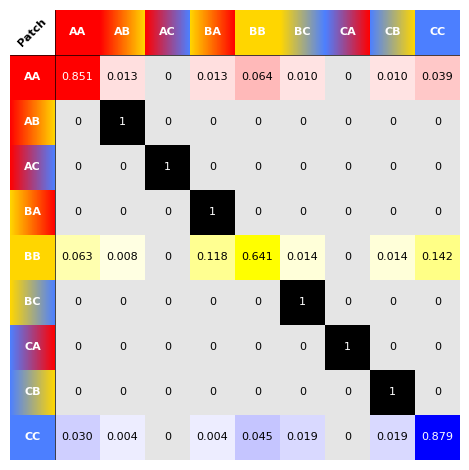

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix
P = np.array([
    [0.851, 0.013, 0,     0.013, 0.064, 0.010, 0,     0.010, 0.039],
    [0,     1,     0,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     1,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     0,     1,     0,     0,     0,     0,     0    ],
    [0.063, 0.008, 0,     0.118, 0.641, 0.014, 0,     0.014, 0.142],
    [0,     0,     0,     0,     0,     1,     0,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     1,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     0,     1,     0    ],
    [0.030, 0.004, 0,     0.004, 0.045, 0.019, 0,     0.019, 0.879]
])

# Normalize and exaggerate smaller values
row_max = P.max(axis=1, keepdims=True)
norm = P / row_max
norm = norm ** 0.5

# Colorize core grid
colored = np.ones(P.shape + (3,))
for i in range(P.shape[0]):
    if i == 0:
        colored[i,:,0] = 1
        colored[i,:,1:] = 1 - norm[i][:, None]
    elif i == 4:
        colored[i,:,0:2] = 1
        colored[i,:,2] = 1 - norm[i]
    elif i == 8:
        colored[i,:,2] = 1
        colored[i,:,:2] = 1 - norm[i][:, None]
    else:
        shade = 1 - norm[i]
        colored[i,:,:] = shade[:, None]
    
    # Light gray for all zeros
    zero_indices = (P[i] == 0)
    colored[i, zero_indices] = [0.9, 0.9, 0.9]


# Labels and base colors
labels = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC', 'CA', 'CB', 'CC']
base_colors = {
    'A': np.array([1.0, 0.0, 0.0]),     # red
    'B': np.array([1.0, 0.84, 0.0]),    # gold
    'C': np.array([0.3, 0.5, 1.0])      # toned blue
}

H, W = P.shape
expanded = np.ones((H + 1, W + 1, 3))
expanded[1:, 1:] = colored

# Solid-color homozygous cells
for j, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[0, j+1, :] = base_colors[label[0]]
for i, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[i+1, 0, :] = base_colors[label[0]]

# Plot base image
fig, ax = plt.subplots()
ax.imshow(expanded, aspect='equal')

# Top label cell gradients (horizontal)
for j, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (j + 1 + k/100 - 0.5001, -0.5001), 1.01/100, 1.01,
                color=grad[k], linewidth=0
            ))


# Side label cell gradients (horizontal)
for i, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (-0.5 + k/100, i + 1 - 0.5), 1/100, 1,
                color=grad[k], linewidth=0
            ))


# Add matrix values
for i in range(H):
    for j in range(W):
        val = P[i, j]
        text = "0" if val == 0 else "1" if val == 1 else f"{val:.3f}"
        r, g, b = colored[i, j]
        brightness = 0.299 * r + 0.587 * g + 0.114 * b
        color = 'black' if brightness > 0.6 else 'white'
        ax.text(j + 1, i + 1, text, ha='center', va='center', color=color, fontsize=8)

# Add label text (always white for contrast)
for j, label in enumerate(labels):
    ax.text(j + 1, 0, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')
for i, label in enumerate(labels):
    ax.text(0, i + 1, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')

# Clean up
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
# Draw thin black lines separating labels and main grid
ax.axhline(0.5, color='black', linewidth=0.5)
ax.axvline(0.5, color='black', linewidth=0.5)
ax.text(0, 0, "Patch", ha='center', va='center', color='black', fontsize=8, fontweight='bold', rotation=45)

plt.tight_layout()
plt.show()


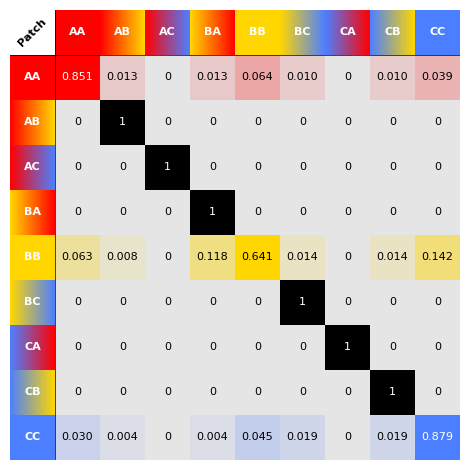

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix
P = np.array([
    [0.851, 0.013, 0,     0.013, 0.064, 0.010, 0,     0.010, 0.039],
    [0,     1,     0,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     1,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     0,     1,     0,     0,     0,     0,     0    ],
    [0.063, 0.008, 0,     0.118, 0.641, 0.014, 0,     0.014, 0.142],
    [0,     0,     0,     0,     0,     1,     0,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     1,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     0,     1,     0    ],
    [0.030, 0.004, 0,     0.004, 0.045, 0.019, 0,     0.019, 0.879]
])

# Normalize and exaggerate smaller values
row_max = P.max(axis=1, keepdims=True)
norm = P / row_max
norm = norm ** 0.5

# Labels and base colors
labels = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC', 'CA', 'CB', 'CC']
base_colors = {
    'A': np.array([1.0, 0.0, 0.0]),     # red
    'B': np.array([1.0, 0.84, 0.0]),    # gold
    'C': np.array([0.3, 0.5, 1.0])      # toned blue
}
gray = np.array([0.9, 0.9, 0.9])

# Colorize core grid: interpolate from gray to row’s base color
colored = np.ones(P.shape + (3,))
for i in range(P.shape[0]):
    base = base_colors[labels[i][0]]
    for j in range(P.shape[1]):
        if P[i, j] == 0:
            colored[i, j] = gray
        elif P[i, j] == 1:
            colored[i, j] = [0, 0, 0]
        else:
            t = norm[i, j]
            colored[i, j] = (1 - t) * gray + t * base

# Expand with label rows/columns
H, W = P.shape
expanded = np.ones((H + 1, W + 1, 3))
expanded[1:, 1:] = colored

# Solid-color homozygous cells
for j, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[0, j+1, :] = base_colors[label[0]]
for i, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[i+1, 0, :] = base_colors[label[0]]

# Plot base image
fig, ax = plt.subplots()
ax.imshow(expanded, aspect='equal')

# Top label cell gradients (horizontal)
for j, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (j + 1 + k/100 - 0.5001, -0.5001), 1.01/100, 1.01,
                color=grad[k], linewidth=0
            ))

# Side label cell gradients (vertical)
for i, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (-0.5 + k/100, i + 1 - 0.5), 1/100, 1,
                color=grad[k], linewidth=0
            ))

# Add matrix values
for i in range(H):
    for j in range(W):
        val = P[i, j]
        text = "0" if val == 0 else "1" if val == 1 else f"{val:.3f}"
        r, g, b = colored[i, j]
        brightness = 0.299 * r + 0.587 * g + 0.114 * b
        color = 'white' if val == 1 or brightness < 0.6 else 'black'
        ax.text(j + 1, i + 1, text, ha='center', va='center', color=color, fontsize=8)

# Add label text
for j, label in enumerate(labels):
    ax.text(j + 1, 0, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')
for i, label in enumerate(labels):
    ax.text(0, i + 1, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')

# Clean up
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.axhline(0.5, color='black', linewidth=0.5)
ax.axvline(0.5, color='black', linewidth=0.5)
ax.text(0, 0, "Patch", ha='center', va='center', color='black', fontsize=8, fontweight='bold', rotation=45)

plt.tight_layout()
plt.show()


(16,)

(14,) (14,)


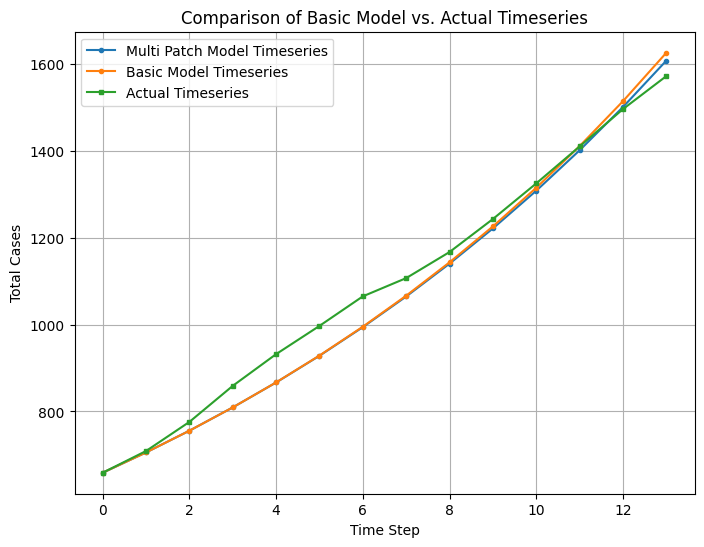

In [21]:
# Plot error for the whole city with basic method
extracted_sol = np.transpose(sol, (1, 2, 0))[2]

total_model_timeseries = np.sum(extracted_sol,axis=0)[0:14]
# total_timeseries = np.sum(all_station_timeseries,axis=0)[0:14]
print(total_model_timeseries.shape,total_timeseries.shape)

model_sol = np.sum(solution_model[2],axis=0)[0:14]


# Plot the two time series against each other
plt.figure(figsize=(8, 6))
plt.plot(model_sol, label="Multi Patch Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_timeseries, label="Actual Timeseries", linestyle='-', marker='s', markersize=3)

# Labels and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Comparison of Basic Model vs. Actual Timeseries")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [102]:
np.sum(extracted_sol,axis=0).shape

(14,)

In [107]:
np.sum(extracted_sol2,axis=1)

array([  94.62154658,  493.51416888,  367.25953266,  139.40105505,
        427.5451871 ,   61.2258197 ,  525.62474603,  266.70035033,
        546.43788236,  496.47499254,  439.52529988,  129.97034253,
        315.31039414,  386.03878216,  499.20781568,  340.72747742,
        174.39972809,  103.43428726,  227.44535972, 1642.75319322,
        501.1280457 ,  299.9049636 ,  200.06565773,  341.0982969 ,
        379.60798181, 1044.20926368,  300.60865594,  348.27784125,
        325.42960659,  557.04068495,  193.90597432,  104.82577185,
        235.62436667,  379.89653478,  948.59419395,  500.60052149,
        226.34793293,  963.46576754,  528.01675093, 1622.36638994,
        250.40406155, 1012.72723107,  503.72721271,  123.3788792 ,
        242.58168572,  343.26179752,  418.43052182,  311.03578622,
        456.48256637,   99.72366065,  780.53482338,  728.57632227,
        567.64842202,  480.18335352,  188.4490632 ,  184.57686171,
        315.65934767,   73.74923173,  280.54908884,  313.08221

In [118]:
sol2.shape

(14, 3)

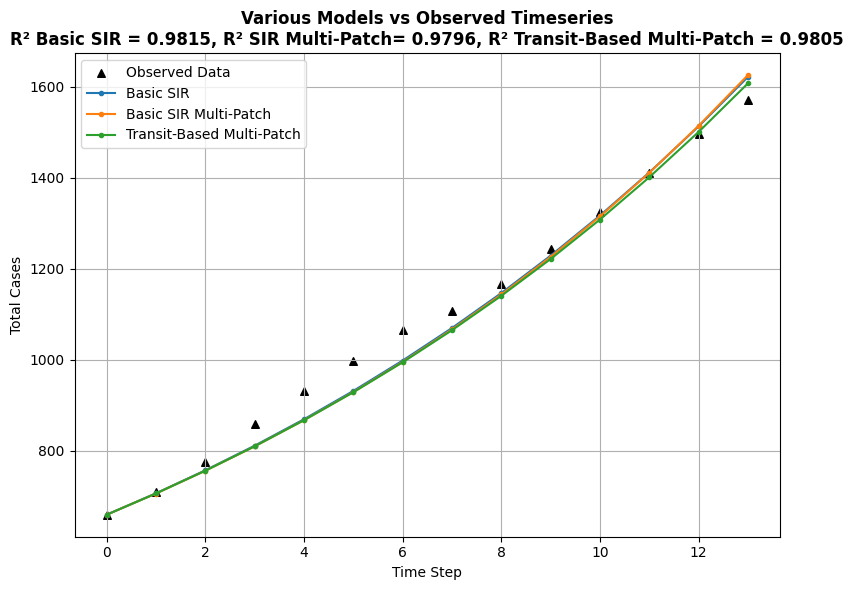

In [24]:
from sklearn.metrics import r2_score

# Extract and sum time series data
extracted_sol = np.transpose(sol, (1, 2, 0))[2]
extracted_sol2 = sol2.T[2]
basic_model_ts = np.sum(extracted_sol, axis=0)
basic_model_ts2 = extracted_sol2
actual_ts = np.sum(all_station_timeseries, axis=0)
multi_patch_ts = np.sum(solution_model[2], axis=0)


# Compute R² values
r2_basic = r2_score(actual_ts, basic_model_ts)
r2_basic2 = r2_score(actual_ts, basic_model_ts2)
r2_multi = r2_score(actual_ts, multi_patch_ts)

# Plot time series comparison
plt.figure(figsize=(8, 6))
plt.scatter(range(len(actual_ts)), actual_ts, label="Observed Data", marker='^', s=30, color='black')
plt.plot(basic_model_ts2, label="Basic SIR", linestyle='-', marker='o', markersize=3)
plt.plot(basic_model_ts, label="Basic SIR Multi-Patch", linestyle='-', marker='o', markersize=3)
plt.plot(multi_patch_ts, label="Transit-Based Multi-Patch", linestyle='-', marker='o', markersize=3)



# Labeling and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title(f"Various Models vs Observed Timeseries\n"
          f"R² Basic SIR = {r2_basic2:.4f}, R² SIR Multi-Patch= {r2_basic:.4f}, R² Transit-Based Multi-Patch = {r2_multi:.4f}",fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


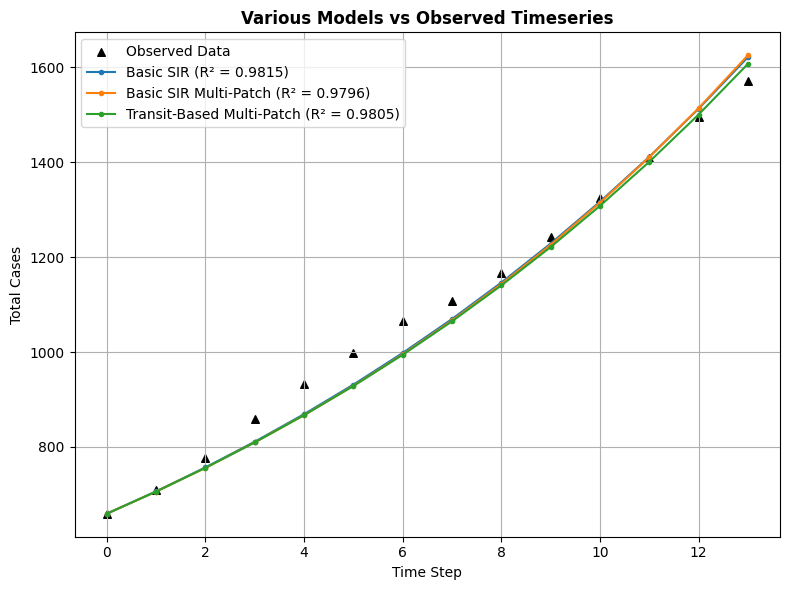

In [25]:
from sklearn.metrics import r2_score

# Extract and sum time series data
extracted_sol = np.transpose(sol, (1, 2, 0))[2]
extracted_sol2 = sol2.T[2]
basic_model_ts = np.sum(extracted_sol, axis=0)
basic_model_ts2 = extracted_sol2
actual_ts = np.sum(all_station_timeseries, axis=0)
multi_patch_ts = np.sum(solution_model[2], axis=0)

# Compute R² values
r2_basic = r2_score(actual_ts, basic_model_ts)
r2_basic2 = r2_score(actual_ts, basic_model_ts2)
r2_multi = r2_score(actual_ts, multi_patch_ts)

# Plot time series comparison
plt.figure(figsize=(8, 6))
plt.scatter(range(len(actual_ts)), actual_ts, label="Observed Data", marker='^', s=30, color='black')
plt.plot(basic_model_ts2, label=f"Basic SIR (R² = {r2_basic2:.4f})", linestyle='-', marker='o', markersize=3)
plt.plot(basic_model_ts, label=f"Basic SIR Multi-Patch (R² = {r2_basic:.4f})", linestyle='-', marker='o', markersize=3)
plt.plot(multi_patch_ts, label=f"Transit-Based Multi-Patch (R² = {r2_multi:.4f})", linestyle='-', marker='o', markersize=3)

# Labeling and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Various Models vs Observed Timeseries", fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
